In [17]:
import ast
import os
import itertools
from collections import Counter
import warnings

import pandas as pd
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer

from preprocessing import * 
from analysis import *
from recommendation_utils import *

warnings.filterwarnings('ignore')

In [2]:
# Read data
games = pd.read_csv("Data/games_detailed_info.csv", index_col=0) # review stats
# 1. Remove columns with > 20% of NA values 
key_columns = keep_columns_with_few_na(games)
# 2. Remove redundant/unnecesary columns
unnecessary_columns = ["type", "thumbnail", "image", "suggested_num_players", "suggested_playerage", 
                       "suggested_language_dependence"]
key_columns = [x for x in key_columns if x not in unnecessary_columns]
# 3. Rename confusing column names
games = games.loc[:,key_columns]

games.rename(columns={"primary": "name", "usersrated": "numratings", "average": "avgrating",
                      "boardgamecategory": "category", "boardgamemechanic": "mechanic", 
                      "boardgamedesigner": "designer", "boardgamepublisher": "publisher", 
                      "bayesaverage": "bayesavgrating", "Board Game Rank": "rank", 
                      "stddev": "stdrating", "median": "medianrating",
                      "owned": "numowned", "trading": "numtrades", "wanting":"numwants", 
                      "wishing": "numwishes", "averageweight":"complexity"}, inplace=True)

# 4. Parse columns with list values
list_colnames = ["category", "mechanic", "designer", "publisher"]

# Convert list of strings to list
games_rec = games.copy()
for list_col in list_colnames:
    games_rec[list_col] = games[list_col].apply(lambda x: ast.literal_eval(x) if not(pd.isna(x)) else [])

# Convert list of strings to separate columns
games = clean_string_format_columns(games, list_colnames)

## Trend anlaysis

### 1. Overall #games published over years

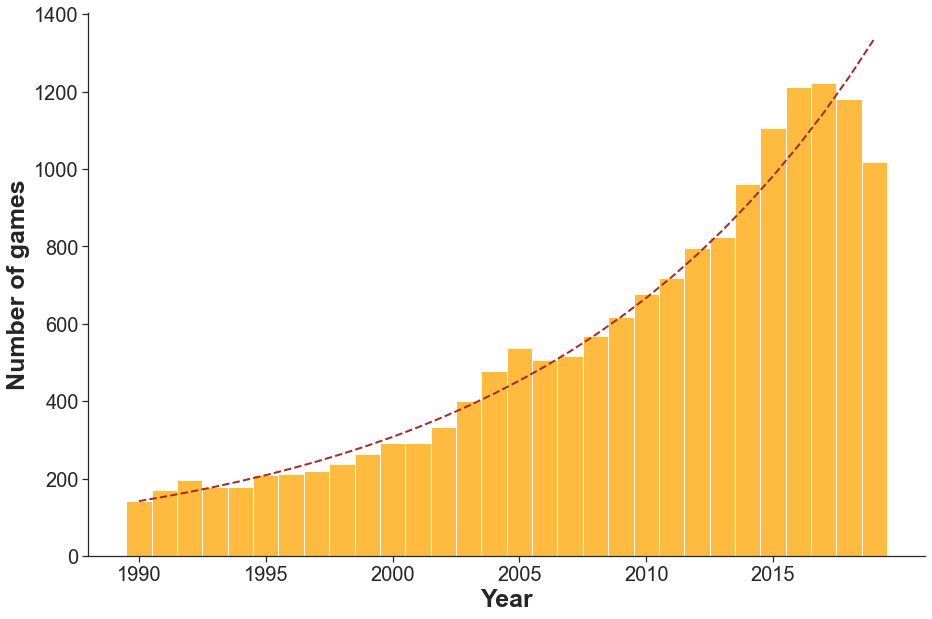

In [3]:
plot_published_games_over_years(games, 1990, 2019, True)

### 2. Average values of game attributes over years

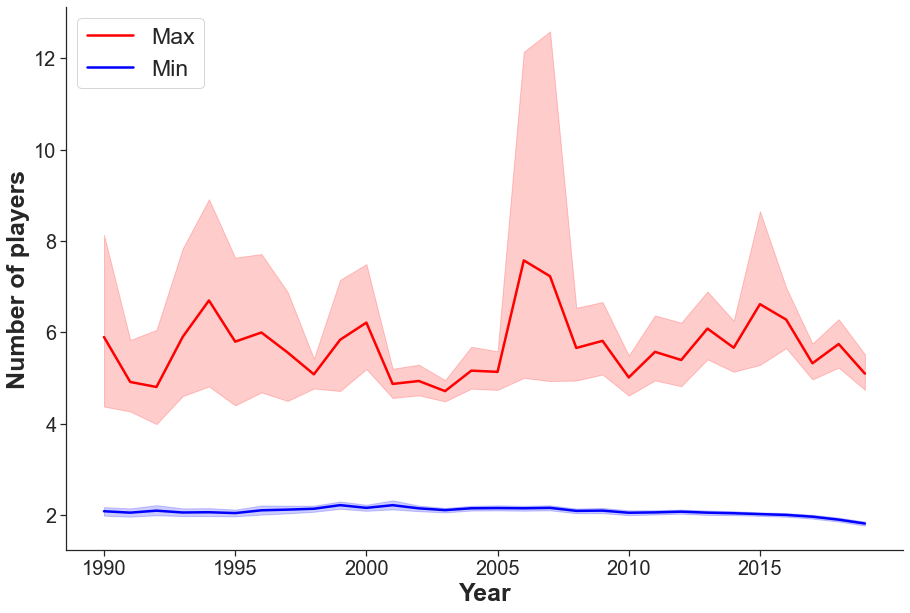

In [4]:
plot_min_max_attributes_over_years(games, 1990, 2019, "minplayers", "maxplayers", "Number of players")

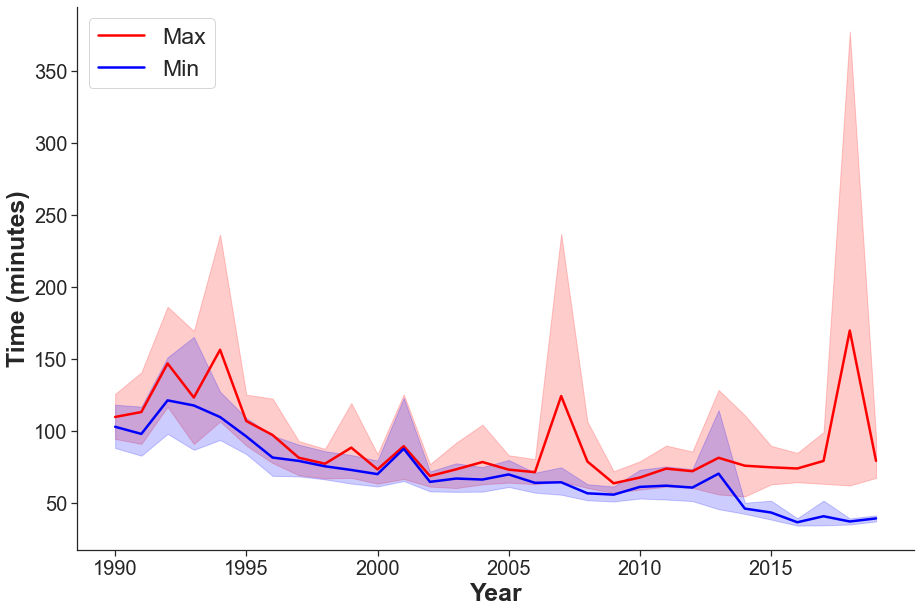

In [5]:
plot_min_max_attributes_over_years(games, 1990, 2019, "minplaytime", "maxplaytime", "Time (minutes)")

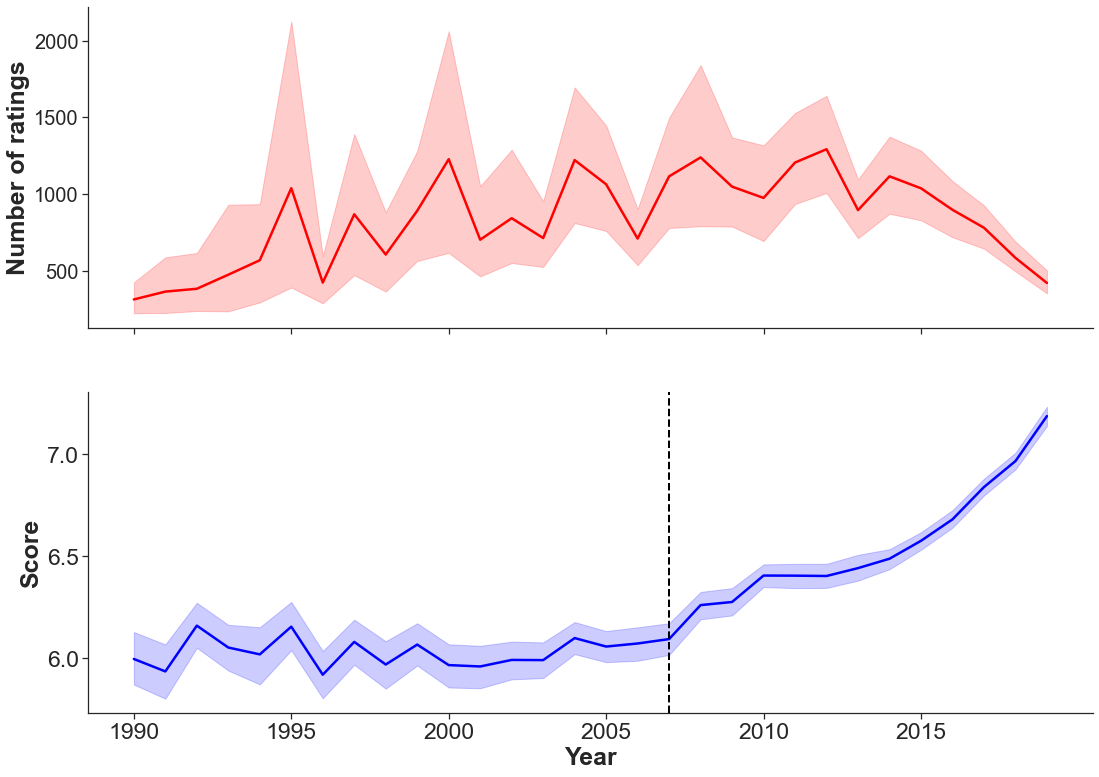

In [6]:
plot_ratings_over_years(games, 1990, 2019, 2007)

## Comparison before & after 2007

### 1. Game description word clouds

In [7]:
ds1 = games.loc[games["yearpublished"] <= 2007, "description"]
ds2 = games.loc[games["yearpublished"] > 2007, "description"]

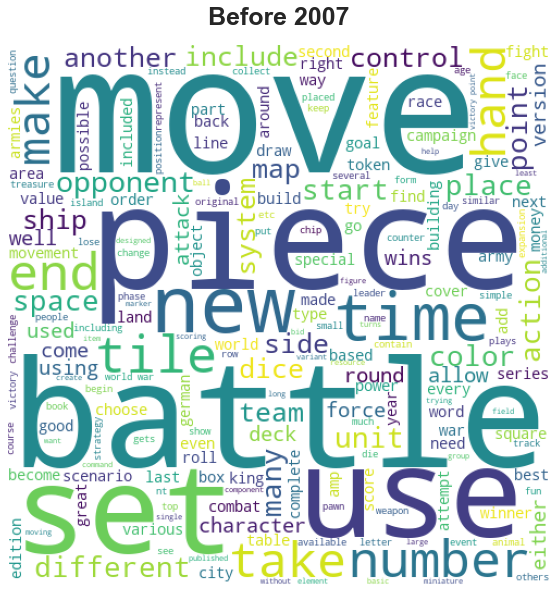

In [8]:
generate_word_cloud(ds1, title="Before 2007")

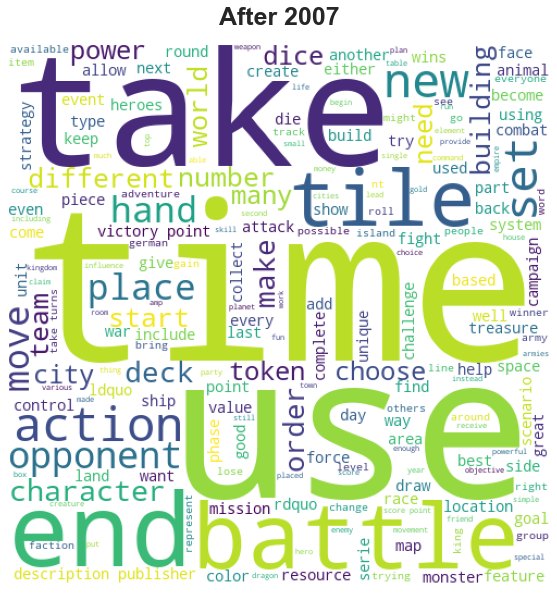

In [9]:
generate_word_cloud(ds2, title="After 2007")

### 2. Top 10 categories/mechanics

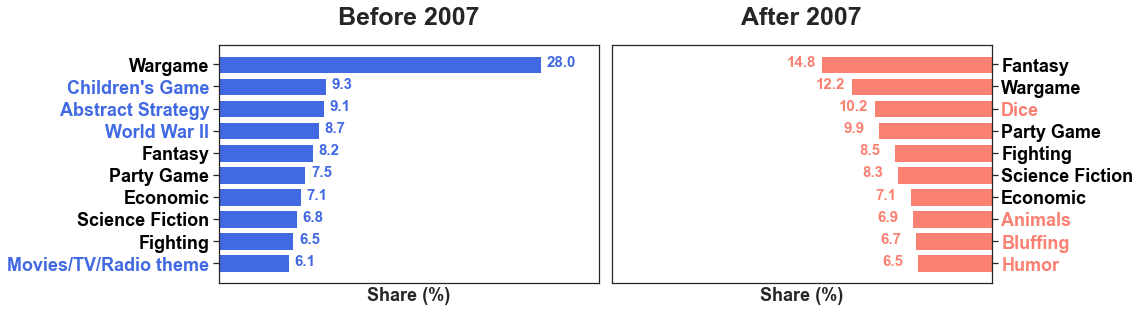

In [10]:
df1, df2, cat_cnts1, cat_cnts2, cat_inters = compare_top_ten_items(games, "category", True, ["'Card Game'"])

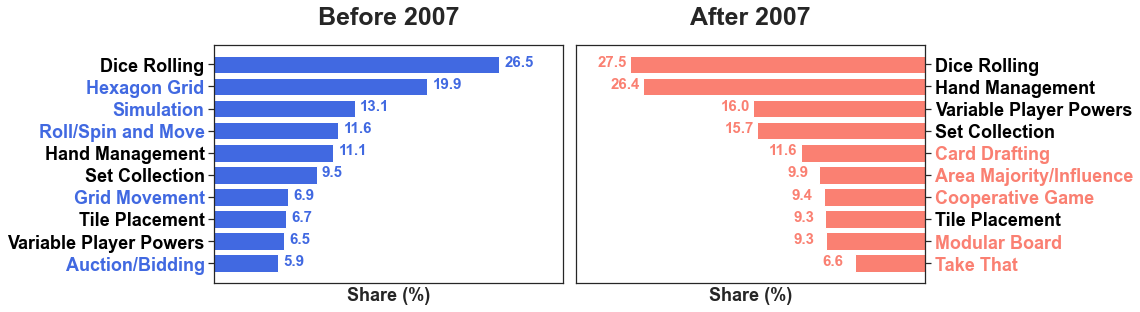

In [11]:
df1, df2, mec_cnts1, mec_cnts2, mec_inters = compare_top_ten_items(games, "mechanic", True, [])

### 3. Transition of overlapping categories/mechanics

In [12]:
population_size1 = df1.shape[0]
population_size2 = df2.shape[0]

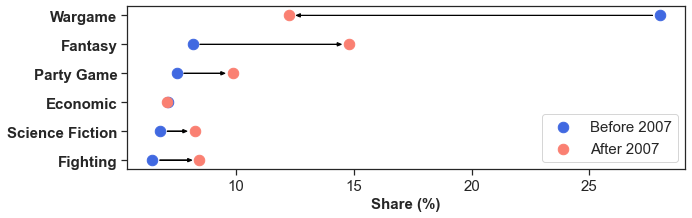

In [13]:
plot_changed_frequencies(cat_inters, cat_cnts1, cat_cnts2, population_size1, population_size2, 2007)

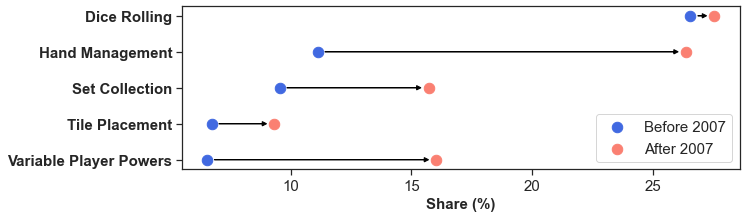

In [14]:
plot_changed_frequencies(mec_inters, mec_cnts1, mec_cnts2, population_size1, population_size2, 2007)

## Recommender

In [15]:
# Load user review data
reviews = pd.read_csv('Data/bgg-15m-reviews.csv', index_col=0)

In [16]:
# Keep top 10000 games
top_10k_games = games_rec[games_rec['rank'] <= 10000].reset_index(drop=True)

# Encode multi-categorical columns
recommendation_df = top_10k_games.copy()
mechanic_encoding = add_encoded_column(recommendation_df, 'mechanic')
category_encoding = add_encoded_column(recommendation_df, 'category')
publisher_encoding = add_encoded_column(recommendation_df, 'publisher', 50, ['(Public Domain)', '(Unknown)', '(Web published)'])
designer_encoding = add_encoded_column(recommendation_df, 'designer', 20, ['(Uncredited)'])


In [18]:
similarity_cols = ['description'
                   , 'category_encoded'
                   , 'mechanic_encoded'
                   , 'publisher_encoded'
                   , 'designer_encoded'
                   , 'complexity'
                  ]

similarity_types = ['text'
                    , 'one_hot'
                    , 'one_hot'
                    , 'one_hot'
                    , 'one_hot'
                    , 'scalar'
                   ]

similarity_weights = [0.1, 0.25, 0.25, 0.1, 0.1, 0.2]

similarity_matrices = get_similarity_matrices(recommendation_df, similarity_cols, similarity_types)

In [20]:
# Recommend games based on similarity scores

game_cb = widgets.Combobox(options=recommendation_df['name'].to_list(), description='Game')
@widgets.interact(name=game_cb)
def display_recommendations(name):
    try:
        return recommend_games(recommendation_df, [name], similarity_matrices, similarity_weights=similarity_weights, num_games=10)
    except AssertionError as e:
        return str(e)

interactive(children=(Combobox(value='', description='Game', options=('Pandemic', 'Carcassonne', 'Catan', '7 W…

In [22]:
# Recommend games to specific user

user = 'HoangBaboo'
game_ratings = user_game_ratings(reviews, user)
games, ratings = zip(*game_ratings)
game_weights = ratings
exclude = []

suggested_games = recommend_games(recommendation_df, games, similarity_matrices,game_weights=game_weights, similarity_weights=similarity_weights, num_games=5, exclude=exclude)

In [23]:
# Display played games
pd.set_option('display.max_colwidth', None)
played_games, played_ratings = zip(*sorted(game_ratings, key = lambda i: i[1], reverse=True))

pd.DataFrame({'name':played_games}).merge(
    recommendation_df, on='name'
)[['name', 'mechanic', 'category', 'complexity']]

,name,mechanic,category,complexity
0,Mythic Battles: Pantheon,"[Area Movement, Campaign / Battle Card Driven, Card Drafting, Cooperative Game, Dice Rolling, Hand Management, Player Elimination, Simulation, Variable Player Powers]","[Ancient, Card Game, Miniatures, Mythology, Wargame]",3.0101
1,Concordia,"[Action Retrieval, Advantage Token, Card Drafting, Hand Management, Movement Points, Moving Multiple Units, Point to Point Movement, Variable Setup]","[Ancient, Economic, Nautical]",3.0391
2,Scythe,"[Area Majority / Influence, Force Commitment, Grid Movement, Hexagon Grid, King of the Hill, Movement Points, Moving Multiple Units, Narrative Choice / Paragraph, Race, Simultaneous Action Selection, Solo / Solitaire Game, Tech Trees / Tech Tracks, Variable Player Powers]","[Economic, Fighting, Science Fiction, Territory Building]",3.4002
3,Splendor,"[Card Drafting, Contracts, Set Collection]","[Card Game, Economic, Renaissance]",1.8005


In [24]:
# Display suggested games
pd.DataFrame({'name':suggested_games}).merge(
    recommendation_df, on='name'
)[['name', 'mechanic', 'category', 'complexity']]

,name,mechanic,category,complexity
0,Concordia Venus,"[Action Retrieval, Card Drafting, Deck, Bag, and Pool Building, Hand Management, Point to Point Movement, Team-Based Game]","[Ancient, Economic]",3.1600
1,7 Wonders,"[Card Drafting, Drafting, Hand Management, Set Collection, Simultaneous Action Selection, Variable Player Powers]","[Ancient, Card Game, City Building, Civilization, Economic]",2.3321
2,51st State,"[Card Drafting, Hand Management, Variable Player Powers]","[Card Game, City Building, Economic, Science Fiction]",3.1144
3,Mundus Novus,"[Card Drafting, Hand Management, Set Collection, Trading]","[Card Game, Economic, Nautical, Renaissance]",2.1863
4,Masters of Renaissance: Lorenzo il Magnifico – The Card Game,"[Card Drafting, Set Collection, Slide/Push]","[Card Game, Economic, Renaissance]",2.2000
